In [8]:
from sklearn.preprocessing import StandardScaler
from utils import *

### Read CSVs

In [ ]:
all_transfers_df = pd.read_csv('../data/all_intra_transfers.csv', index_col=[0]) # excluding zero-value transfers does not make a significant difference for the resulting graph (nodes: 51566, edges: 249302)
ens_pairs = pd.read_csv('../data/ens_pairs.csv', index_col=[0])

### Prepare network graph

In [6]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.MultiDiGraph())
G = clean_graph(G)

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc)

# Recode the graph's nodes, node_map maps from address to index
G_cc, node_map = recode_graph(G_cc)

# Create reverse map (from indices to addresses)
idx_map = dict(zip(node_map.values(),node_map.keys()))
ordered_addresses = [idx_map[idx] for idx in range(len(node_map))]

print(f'Nodes: {len(G_cc.nodes())}\nEdges: {len(G_cc.edges())}')

Nodes: 51566
Edges: 249302


### Run models once and store the embeddings as a dataframe

In [32]:
# Diff2Vec
diff2vec = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025)
embeddings_d2v, emb_d2v_df = fit_model(G_cc, diff2vec, ordered_addresses)
emb_d2v_df.to_csv('../data/embeddings/diff2vec.csv')

# Role2Vec
role2vec = Role2Vec(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_r2v, emb_r2v_df = fit_model(G_cc, role2vec, ordered_addresses)
emb_r2v_df.to_csv('../data/embeddings/role2vec.csv')

# DeepWalk
deepWalk = DeepWalk(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_dw, emb_dw_df = fit_model(G_cc, deepWalk, ordered_addresses)
emb_dw_df.to_csv('../data/embeddings/deepWalk.csv')

## Evaluation: Conduct 10 separate experiments and store the average ranks for each model

In [20]:
def calculate_average_rank(model, iterations=5):
    rank_arr = []

    for i in tqdm(range(iterations)):
        embeddings, emb_df = fit_model(G_cc, model, ordered_addresses)
        faiss_index = DistCalculation(embeddings, node_map)

        ranks = []
        for _, row in ens_pairs.iterrows():
            rank, _ = faiss_index.foo(row['addr1'], row['addr2'])
            ranks.append(rank)

        # Add the ranks to the array
        rank_arr.append(ranks)

    rank_arr = np.array(rank_arr)
    # Convert None values to np.nan
    rank_arr = [[np.nan if val is None else val for val in sublist] for sublist in rank_arr]
    average_rank = np.nanmean(rank_arr, axis=0)

    return average_rank

In [21]:
# Diff2Vec
diff2vec = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025)
average_rank_diff2vec = calculate_average_rank(diff2vec, iterations=10)
average_rank_diff2vec

100%|██████████| 10/10 [1:48:29<00:00, 650.93s/it]
/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_67154/4103458106.py:19: RuntimeWarning: Mean of empty slice
  average_rank = np.nanmean(rank_arr, axis=0)


array([  2.5, 577.3,   2.8, 106.8,   nan,  11.1,  30.7,  44.3,  16.3,
         1. , 129.1,   nan,   1. ,   1.9,  10.4,   4. ,   4.2,   5.7,
        52.3,   9. , 474.2,   1.7,   2.7,   1.3,   1. ,   3.7,  16.9,
         3.6,   1.5,   2.7,   2. ,  64.8,   3. ,  11. ,  52.1,  10.3,
         4.2,   2.3,  34. ])

In [22]:
# Role2Vec
role2vec = Role2Vec(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
average_rank_role2vec = calculate_average_rank(role2vec, iterations=10)
average_rank_role2vec

100%|██████████| 10/10 [1:37:16<00:00, 583.60s/it]
/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_67154/4103458106.py:19: RuntimeWarning: Mean of empty slice
  average_rank = np.nanmean(rank_arr, axis=0)


array([  6.2,  33.3,   2.5,  71.1,   nan,   3. ,   1. ,  91.2,  10.4,
         1. ,  10. ,   nan,   1. ,   1. ,   1. ,   1. ,   1.5,   5.6,
       373.8,   9. ,  86.7,   5. ,   1. ,   3.4,   1. ,   2. ,  14.4,
         2.6,   2. ,   1. ,   2. ,  13.6,   1.1,  19.3,   5.6,  68.9,
         4. ,   2.9, 178.6])

In [23]:
# DeepWalk
deepWalk = DeepWalk(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
average_rank_deepWalk = calculate_average_rank(deepWalk, iterations=10)
average_rank_deepWalk

100%|██████████| 10/10 [41:27<00:00, 248.74s/it]
/var/folders/6y/q2mh3ct92xx9v05c53h84l6c0000gn/T/ipykernel_67154/4103458106.py:19: RuntimeWarning: Mean of empty slice
  average_rank = np.nanmean(rank_arr, axis=0)


array([  2.7,  58.8,   3.3,  20.1,   nan,   1.4,   1. , 545.4,   4.1,
         1. , 605.4,   nan,   1.8,   1. ,   1. ,  18.2,  10.3,  27.2,
       108.5,   9. ,  51.8,   2.4,   1. ,   2.3,   2.4,   2.2, 284. ,
         2.2,   1.7,   1.6,   1.1, 101.2,   1.6,   1.7,   3.4,  47.3,
       227. ,   3.4, 138.6])

### Combine the results and compute mean, median and std for each method

In [24]:
# Combine numpy arrays
average_rank_array = np.column_stack((average_rank_diff2vec, average_rank_role2vec, average_rank_deepWalk))
average_rank = pd.DataFrame(average_rank_array, columns=['Diff2Vec', 'Role2Vec', 'DeepWalk'])
average_rank.to_csv('../data/average_rank.csv', index=False)

# Calculate stats
mean = average_rank.mean()
median = average_rank.median()
std = average_rank.std()

# Print results
print('Mean:\n', mean)
print('\nMedian:\n', median)
print('\nStandard Deviation:\n', std)

Mean:
 Diff2Vec    46.037838
Role2Vec    28.072973
DeepWalk    62.083784
dtype: float64

Median:
 Diff2Vec    4.2
Role2Vec    3.4
DeepWalk    3.3
dtype: float64

Standard Deviation:
 Diff2Vec    120.504083
Role2Vec     68.814003
DeepWalk    139.931865
dtype: float64


### Initialize distance calculation classes

In [ ]:
#Diff2Vec
emb_d2v_df = pd.read_csv('../data/embeddings/diff2vec.csv', index_col='address')
embeddings_d2v = emb_d2v_df.values
faiss_index_d2v = DistCalculation(embeddings_d2v, node_map)

#Role2Vec
emb_r2v_df = pd.read_csv('../data/embeddings/role2vec.csv', index_col='address')
embeddings_r2v = emb_r2v_df.values
faiss_index_r2v = DistCalculation(embeddings_r2v, node_map)

#Deepwalk
emb_dw_df = pd.read_csv('../data/embeddings/deepWalk.csv', index_col='address')
embeddings_dw = emb_dw_df.values
faiss_index_deepWalk = DistCalculation(embeddings_dw, node_map)

In [7]:
# Prepare stats
timeOfDay = pd.read_csv('../data/timeOfDay.csv', index_col='from')
normalizedGas = pd.read_csv('../data/normalizedGas.csv', index_col='from')
stats_df = timeOfDay.merge(normalizedGas, left_index=True, right_index=True, how='inner')

# Normalize
scaler = StandardScaler()
stats_normalized = pd.DataFrame(scaler.fit_transform(stats_df), columns=stats_df.columns, index=stats_df.index)

def filter_dataframe(df, argument, include_hist=False):
    if argument.lower() == 'tod':
        # keep only the 'ToD' related columns
        selected_columns = [col for col in df.columns if 'ToD' in col]
    elif argument.lower() == 'normalized_gasprice':
        # keep only the 'normalized_gasPrice' related columns
        selected_columns = [col for col in df.columns if 'normalized_gasPrice' in col]
    elif argument.lower() == 'both':
        # keep both 'ToD' and 'normalized_gasPrice' related columns
        selected_columns = df.columns
    else:
        raise ValueError("Invalid argument. Expected 'ToD', 'normalized_gasPrice', or 'both'.")

    if not include_hist:
        # If include_hist is False, remove columns with 'hist_bin_' in their names
        selected_columns = [col for col in selected_columns if 'hist_bin_' not in col]

    return df[selected_columns]


def compute_relative_rank(df, source_address, target_address, num_neighbors=50):

    if source_address in node_map and target_address in node_map:
        # Get k nearest neighbors for specified address (default 50)
        D, I = faiss_index_d2v.get_dist_idx(node_map[source_address])
        nearest_neighbors = list(I[0:num_neighbors])
        nearest_neighbors_addresses = [idx_map[j] for j in nearest_neighbors]
        nearest_neighbors_addresses.insert(0, source_address)
        if target_address not in nearest_neighbors_addresses:
            print(f'Target address not in nearest {num_neighbors} neighbors')
            return None

        # Further filter the dataframe
        df_filtered = df[df.index.isin(nearest_neighbors_addresses)]

        # Compute the Euclidean distance between the source address and all other addresses
        distances = np.linalg.norm(df_filtered.loc[source_address] - df_filtered, axis=1)

        # Convert the distances to a DataFrame
        df_distances = pd.DataFrame(distances, columns=['distance'], index=df_filtered.index)
        df_distances.sort_values(by='distance', inplace=True)

        target_rank = df_distances.index.get_loc(target_address)

        return target_rank
    else:
        return None


# Quick test
df = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=False)
source_address = '0x5500c014dc83d18c60858195b42f2e61f877323e'
target_address = '0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4'
rank = compute_relative_rank(df, source_address, target_address)
print(rank)

In [14]:
d2v_ens = d2v_ens[d2v_ens['rank'] <= 50]

ToD_noHist = filter_dataframe(stats_normalized, 'ToD', include_hist=False)
d2v_ens['ToD_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(ToD_noHist, row['addr1'], row['addr2']),
    axis=1
)

ToD_Hist = filter_dataframe(stats_normalized, 'ToD', include_hist=True)
d2v_ens['ToD_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(ToD_Hist, row['addr1'], row['addr2']),
    axis=1
)

nGas_noHist = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=False)
d2v_ens['nG_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(nGas_noHist, row['addr1'], row['addr2']),
    axis=1
)

nGas_Hist = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=True)
d2v_ens['nG_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(nGas_Hist, row['addr1'], row['addr2']),
    axis=1
)

both_noHist = filter_dataframe(stats_normalized, 'both', include_hist=False)
d2v_ens['both_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(both_noHist, row['addr1'], row['addr2']),
    axis=1
)

both_Hist = filter_dataframe(stats_normalized, 'both', include_hist=True)
d2v_ens['both_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(both_Hist, row['addr1'], row['addr2']),
    axis=1
)


# Compute mean and median of numeric columns
numeric_cols = d2v_ens.select_dtypes(include=[np.number])
df_mean = numeric_cols.mean()
df_median = numeric_cols.median()
df_std = np.std(numeric_cols)

# Append mean and median to the dataframe
df_final = d2v_ens.append(df_mean, ignore_index=True)
df_final = df_final.append(df_median, ignore_index=True)
df_final = df_final.append(df_std, ignore_index=True)
df_final

,addr1,addr2,rank,distance,rank_ToD_noHist,rank_ToD_Hist,rank_nG_noHist,rank_nG_Hist,rank_both_noHist,rank_both_Hist
0,0x85e5472752a6f00775faca4d5179bde1081571b0,0xbf886e3069d0dfd64e384c93da322f775faa8876,1.000000,0.540400,5.000000,6.000000,35.000000,35.000000,18.000000,15.000000
1,0x5500c014dc83d18c60858195b42f2e61f877323e,0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4,3.000000,0.744784,6.000000,2.000000,17.000000,11.000000,5.000000,2.000000
2,0xb84914f420b6de809ac1ed3d4427d90ed596b41c,0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072,5.000000,1.168792,15.000000,34.000000,43.000000,42.000000,28.000000,37.000000
3,0x05c351382db8d770207f319d96ac1184c3717ede,0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d,45.000000,1.320000,4.000000,9.000000,15.000000,18.000000,1.000000,10.000000
4,0x26846c9083c4ab525de593178e3f2f82afb8ba83,0x0786a24145fef2c60a38237e8671332899ce7c1f,9.000000,1.037913,1.000000,25.000000,30.000000,25.000000,11.000000,24.000000
5,0xe005c90eb8b38938cfe722e7069118414145709b,0xd9c0e1af68d08c8c00d418431e8c036662a82e37,1.000000,0.864102,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
6,0x1a26db1b2baf0b23f18e19375e8fdc159feb707e,0x33321e44c2861033fb80ad04f93e4ccd25f2beef,1.000000,0.671990,28.000000,27.000000,8.000000,11.000000,27.000000,25.000000
7,0x250fbb28b2cd0a9faadc2d8a1d1c72f69163ac29,0xc0a527d87baf6f288074df53dd0fbba575e7547e,2.000000,0.607648,2.000000,2.000000,39.000000,34.000000,15.000000,10.000000
8,0x84ab65f45d3f8067f8bbff80f2248cd1ab4d96be,0x9c1bbcc03b59e78410de1d0ba9305082fedad3bb,13.000000,0.983868,4.000000,4.000000,38.000000,36.000000,7.000000,5.000000
9,0x580bb63d47242964fa5fe9e69c5eb5423b7a50d2,0x7bd544f07afa4284a696dc71e7a03f680dca0543,5.000000,0.760373,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000


### Time of day

0x76232accd8b6e1827a00462abd9b3cffcad68b9e 15
0xaa68328e0dd8e7ecde1b6c7a01e552c5e33df563 8


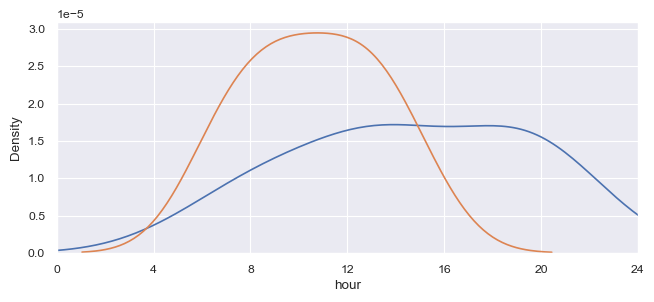

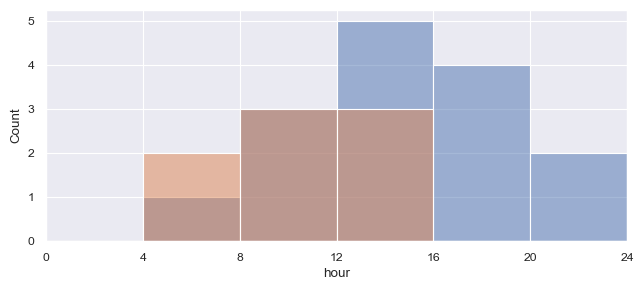

In [47]:
addresses = [idx_map[i] for i in [487, 493]]

show_patterns(all_transfers_df, addresses, hour_bins=6, show_kde=True)

### Find a way to cluster the addresses instead of k nearest neighbors

Do it with different tresholds, see how the number of clusters changes, visualize it

In [16]:
# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.8

print(embeddings_d2v.shape[0])

# Iterate over all embeddings
for i in range(embeddings_d2v.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = faiss_index_d2v.get_dist_idx(i)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    if not neighbours:
        neighbours = set([i])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters

51566
36253


[{47489, 48488},
 {0},
 {23863, 26275, 27046, 27571},
 {36886, 36962},
 {4},
 {5},
 {6},
 {548, 551},
 {359, 38896, 38900},
 {9},
 {324, 327, 3100},
 {134, 139},
 {12},
 {19516, 19557},
 {14, 137},
 {15},
 {44, 132},
 {18095, 45561},
 {508, 509},
 {19},
 {20},
 {21, 453},
 {22, 502},
 {23},
 {350, 37410, 37415},
 {25},
 {26},
 {27},
 {38030, 38215},
 {24952, 25733},
 {30},
 {31},
 {32},
 {39787, 39792, 39797},
 {34},
 {12423, 12427},
 {36},
 {12679, 45893, 45894},
 {16132, 42058, 48975},
 {39},
 {39563, 39576},
 {13173, 13191},
 {9098, 9107},
 {30451, 46003},
 {132},
 {9395, 13443, 15691},
 {46},
 {47, 80},
 {48},
 {49},
 {38500, 38515},
 {20015, 47946},
 {52},
 {53},
 {40807, 48240, 48644},
 {55},
 {56},
 {57},
 {9274, 9367},
 {59},
 {60},
 {8329, 33610, 33624},
 {62},
 {63},
 {43074, 43075},
 {50300, 50303, 50305},
 {66},
 {67},
 {68},
 {13295, 45604, 47314},
 {70},
 {71},
 {30242, 30243},
 {21129, 31177, 45141},
 {42394, 45413},
 {75},
 {76},
 {77, 563},
 {1200, 32246, 39441},
 {79,